# **Image Classification (CIFAR10)**

### **1)MLP Model**
### **2)CNN Model**

# 0. Important necessary modules

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt

# 1.Data Preparation

The **CIFAR-10** dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. (https://www.cs.toronto.edu/~kriz/cifar.html)


The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

**Data Set**  
$$X_{train} \in \mathcal{R}^{40000 \times 1024}, Y_{train} \in \mathcal{Z}^{40000}$$  
$$X_{val} \in \mathcal{R}^{10000 \times 1024}, Y_{val} \in \mathcal{Z}^{10000}$$  
$$X_{test} \in \mathcal{R}^{10000 \times 1024}, Y_{test} \in \mathcal{Z}^{10000}$$

### Data loading using dataloader

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(valset, batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Inspecting dataset

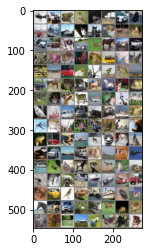

plane truck  frog  bird  bird truck   car   cat  ship  ship  ship   cat horse   dog  deer  bird   car truck   dog  ship  deer horse plane   car  bird  frog  frog  frog  frog  ship plane  frog horse plane truck   dog plane  bird  frog  ship truck horse  frog truck horse horse   dog  frog  deer   cat   dog   cat plane  bird horse horse  bird  ship  ship   car plane   car  ship  bird plane   cat truck  frog  bird  bird   cat   cat  frog   car  frog  ship  deer  bird   dog   dog   cat   car  ship truck   cat plane   cat plane  ship  frog   cat horse  bird plane   cat truck  bird  deer   dog horse  ship  ship truck truck  frog   car  bird  frog truck  ship  bird   dog horse  deer   car  deer  bird horse  deer  bird  deer  frog  deer plane horse   car   dog   dog
<class 'torch.Tensor'> torch.Size([128, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([128]) tensor([0, 9, 6, 2, 2, 9, 1, 3, 8, 8, 8, 3, 7, 5, 4, 2, 1, 9, 5, 8, 4, 7, 0, 1,
        2, 6, 6, 6, 6, 8, 0, 6, 7, 0, 9, 5, 0, 2, 6, 8, 9, 

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

print(type(images), images.shape)
print(type(labels), labels.shape, labels)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Checking GPU

In [4]:
print(torch.cuda.is_available())
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

True


# 2. Model Define

### **MLP Model**

### **CNN Model**

In [5]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3,     # 128 x 3 x 32 x 32 = batch_size x channel (color) x width x height
                               out_channels = 64,
                               kernel_size = 3,
                               stride = 1,
                               padding= 1)
        
        self.conv2 = nn.Conv2d(in_channels = 64,
                               out_channels = 256,
                               kernel_size = 5,
                               stride = 1,
                               padding= 2)
        self.act = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,
                                     stride=2)
        self.fc = nn.Linear(65536, 10) # 256 x 16 x 16 after maxpooling(2x2) <== 256 x 32 x 32

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 3. Simulation Define

In [8]:
def experiment(args):
    #model = MLPModel(args.in_dim, args.out_dim, args.hid_dim, args.n_layers, args.act, args.dropout, args.use_bn, args.use_xavier)
    model = CNN()
    model.to(device)
    print(model)

    # ====== Loss function ====== #
    #criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss() #Image classification

    optimizer = optim.SGD(model.parameters(), lr=args.lr)

    # ====== Data collection ====== #
    list_epoch = [] 
    list_train_loss = []
    list_val_loss = []
    list_acc = []
    list_acc_epoch = []

    # ====== Loop ====== #
    for epoch in range(args.epoch):  
        
        # ====== Train ====== #
        model.train() # Set the model be 'train mode' 
        train_loss = 0 # to sum up each batch
        
        for input_x, true_y in train_loader:
            optimizer.zero_grad() # Initialize the gradient in the optimizer

 #            input_X = input_X.squeeze()
 #           input_X = input_X.view(-1, 784)

            input_x = input_x.to(device)
            true_y = true_y.to(device)

            pred_y = model(input_x)

 #           loss = criterion(pred_y.squeeze(), true_y)
            loss = criterion(pred_y, true_y)
            loss.backward()
            optimizer.step()
            train_loss +=loss.item()
      
        train_loss = train_loss / len(train_loader)
        list_train_loss.append(train_loss)
        list_epoch.append(epoch)

        # ====== Validation ====== #
        model.eval() # Set the model be 'train mode' 
        val_loss = 0 # to sum up each batch
        
        with torch.no_grad():
            for input_x, true_y in val_loader:

 #               input_X = input_X.squeeze()
 #               input_X = input_X.view(-1, 784)

                input_x = input_x.to(device)
                true_y = true_y.to(device)

                pred_y = model(input_x)

 #               loss = criterion(pred_y.squeeze(), true_y)
                loss = criterion(pred_y, true_y)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)

        # ====== Evaluation ====== #
        model.eval() # Set the model be 'train mode' 
        correct = 0 # to sum up each batch
        
        with torch.no_grad():
            for input_x, true_y in test_loader:

#                input_X = input_X.squeeze()
#                input_X = input_X.view(-1, 784)

                input_x = input_x.to(device)
                true_y = true_y.to(device)

                pred_y = model(input_x).max(1, keepdim=True)[1].squeeze()
                correct += pred_y.eq(true_y).sum()

            acc = correct.item() / len(test_loader.dataset)
            list_acc.append(acc)
            list_acc_epoch.append(epoch)
        
        print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(epoch, train_loss, val_loss, acc*100))

    return list_epoch, list_train_loss, list_val_loss, list_acc, list_acc_epoch

In [9]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()

args = parser.parse_args("")

#args.n_layer = 5
#args.in_dim = 3072
args.out_dim = 10
#args.hid_dim = 100
args.act = 'relu'
args.lr = 0.01
args.mm = 0.75
args.epoch = 25
#args.dropout = 0.1
#args.bn = True
#args.xavier = True

list_epoch, list_train_loss, list_val_loss, list_acc, list_acc_epoch = experiment(args)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=65536, out_features=10, bias=True)
)
Epoch: 0, Train Loss: 1.8178753868078652, Val Loss: 1.6159718459165548, Test Acc: 42.71%
Epoch: 1, Train Loss: 1.5106939587730188, Val Loss: 1.4372872823401341, Test Acc: 49.63%
Epoch: 2, Train Loss: 1.3643329375848983, Val Loss: 1.327800150159039, Test Acc: 52.89%
Epoch: 3, Train Loss: 1.2693648370691002, Val Loss: 1.279939535297925, Test Acc: 54.410000000000004%
Epoch: 4, Train Loss: 1.1981344388696713, Val Loss: 1.2541326616383806, Test Acc: 56.010000000000005%
Epoch: 5, Train Loss: 1.1381821371495915, Val Loss: 1.1721295480486713, Test Acc: 58.76%
Epoch: 6, Train Loss: 1.0843510065977566, Val Loss: 1.1357525013670136, Test Acc: 60.35%
Epoch: 7, Train Loss: 1.0

# 5. Report

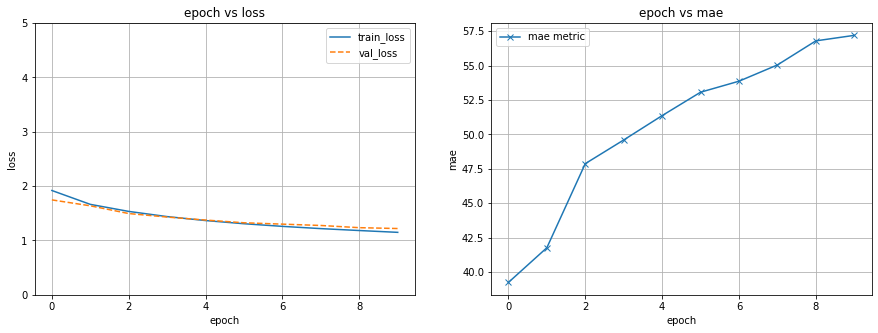

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()